In [6]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
import numpy as np
from time import time
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm
from scipy.sparse import issparse
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
%matplotlib inline
#feature and dimension expand, why?
#what if we only use original features?
#Assume we have five orignal features: amt, paymtd, paytype, RecorPay, beneficiary
#dictionary for each feature is as following, all features are categorical data:
##Amt:0-9 (Amount of each txn)
##Paymtd:0-9 (payment method of each txn)
##Paytype:0-9 (payment type of each txn)
##RecorPay:0-9 (receive or pay type of each txn)
##bene:0-9 (beneficiary of each txn)

class Sythetic:
    def __init__(self):
        print('Sythetic instance has been created!')
        
    def Kmeans(self,data,K,plt):
        sse = {}
        t0=time()
        for k in tqdm(range(1, K+1)):
            kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data)
            sse[k] = kmeans.inertia_ 
        t1=time()
        plt.plot(list(sse.keys()), list(sse.values()))
        plt.set_title('Kmeans')
        plt.set_xlabel("Number of cluster")
        plt.set_ylabel("SSE")
        print('Kmeans running time:%f sec!'%(t1-t0))
        return sse
        
    def SVD(self,data,K,plt):
        t0=time()
        svd=TruncatedSVD(n_components=K,n_iter=500,random_state=0)
        svd.fit(data)
        sigma=svd.singular_values_
        t1=time()
        x=[i for i in range(1,K+1)]
        plt.plot(x,sigma)
        plt.set_title('SVD')
        plt.set_xlabel("Singular Value Position")
        plt.set_ylabel("Singular Value")
        print('SVD running time:%f sec!'%(t1-t0))
        return sigma, svd.explained_variance_ratio_,svd.explained_variance_ratio_.sum()
        
    
    def PCA(self,data,K,plt):
        sparse=issparse(data)
        t0=time()
        pca = PCA(n_components=K)
        if sparse:
            pca.fit(data.toarray())
        else:
            pca.fit(data)
        sigma=pca.singular_values_
        t1=time()
        x=[i for i in range(1,K+1)]
        plt.plot(x,sigma)
        plt.set_title('PCA')
        plt.set_xlabel("Singular Value Position")
        plt.set_ylabel("Singular Value")
        print('PCA running time:%f sec!'%(t1-t0))
        return sigma, pca.explained_variance_ratio_,pca.explained_variance_ratio_.sum()
        
    def NMF(self,data,K,plt):
        re = {}
        t0=time()
        for k in tqdm(range(1, K+1)):
            nmf = NMF(n_components=k, max_iter=1000).fit(data)
            re[k] = nmf.reconstruction_err_  
        t1=time()
        plt.plot(list(re.keys()), list(re.values()))
        plt.set_title('NMF')
        plt.set_xlabel("Number of cluster")
        plt.set_ylabel("Reconstruction-error")
        print('NMF running time:%f sec!'%(t1-t0))
        return re
    
    def LDA(self,data,K,plt):
        t0=time()
        coherence_values = []
        data=[[str(word) for word in doc] for doc in data]
        id2word=corpora.Dictionary(data)
        corpus = [id2word.doc2bow(text) for text in data]
        for num_topics in tqdm(range(1,K+1)):
            model=gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                   id2word=id2word,
                                                   num_topics=num_topics, 
                                                   random_state=0,
                                                   update_every=1,
                                                   alpha='auto',
                                                   per_word_topics=True)
            coherencemodel = CoherenceModel(model=model, texts=data, dictionary=id2word, coherence='c_v')
            coherence_values.append(coherencemodel.get_coherence())
        t1=time()
        x=[i for i in range(1,K+1)]
        plt.plot(x,coherence_values)
        plt.set_title('LDA')
        plt.set_xlabel("Number of cluster")
        plt.set_ylabel("Coherence score")
        print('LDA running time:%f sec!'%(t1-t0))
        return coherence_values

    def Kmeans_pred(self,data,K,real_label):
        kmeans=KMeans(n_clusters=K,max_iter=1000)
        kmeans_pred=kmeans.fit_predict(data)
        conf_mat=confusion_matrix(real_label,kmeans_pred)
        return kmeans_pred,conf_mat
    
    def NMF_pred(self,data,K,real_label):
        nmf=NMF(n_components=K, max_iter=1000)
        W=nmf.fit_transform(data)
        nmf_pred=[np.argmax(i) for i in W]
        conf_mat=confusion_matrix(real_label,nmf_pred)
        return nmf_pred,conf_mat
    
    def LDA_pred(self,data,K,real_label):
        data=[[str(word) for word in doc] for doc in data]
        id2word=corpora.Dictionary(data)
        corpus = [id2word.doc2bow(text) for text in data]
        model=gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=K, 
                                               random_state=0,
                                               update_every=1,
                                               alpha='auto',
                                               per_word_topics=True)
        topic_dist=model.get_document_topics(corpus)
        topic_dist=[list(zip(*i))[1] for i in list(topic_dist)]
        LDA_pred=[np.argmax(np.array(i)) for i in topic_dist]
        conf_mat=confusion_matrix(real_label,LDA_pred)
        return LDA_pred,conf_mat
    
    def sub_plot_K(self,data,K):
        fig = plt.figure(figsize=(18,10))
        ax1=fig.add_subplot(231)
        self.Kmeans(data,K,ax1)
        ax2=fig.add_subplot(232)
        self.SVD(data,K,ax2)
        ax3=fig.add_subplot(233)
        self.PCA(data,K,ax3)
        ax4=fig.add_subplot(234)
        self.NMF(data,K,ax4)
        ax5=fig.add_subplot(235)
        self.LDA(data,K,ax5)
        plt.show()
        
    def conf_mat(self,data,K,real_label):
        print('*********K-means*********')
        print(self.Kmeans_pred(data,K,real_label)[1])
        print('*********NMF*************')
        print(self.NMF_pred(data,K,real_label)[1])
        print('*********PCA*************')
        sparse=issparse(data)
        if sparse:
            print(self.Kmeans_pred(PCA(K).fit_transform(data.toarray()),K,real_label)[1])
        else:
            print(self.Kmeans_pred(PCA(K).fit_transform(data),K,real_label)[1])
        print('*********SVD**************')
        print(self.Kmeans_pred(TruncatedSVD(K).fit_transform(data),K,real_label)[1])
        print('*********LDA**************')
        print(self.LDA_pred(data,K,real_label)[1])
        
s=Sythetic()

Sythetic instance has been created!


In [120]:
class txn_class():
    def __init__(self,feat_num=3,feat_prob=[[0.9,0.1,0,0],
                                            [0.1,0.9,0],
                                            [0.2,0.8]]):
        if (len(feat_prob)!=feat_num):
            print('The feature number does not match the prob length!')
            raise ValueError
        self.feat_num=feat_num
        self.feat_prob=feat_prob
    
    def generat(self):
        txn=[]
        for feat in range(self.feat_num):
            feat_data=np.random.choice(len(self.feat_prob[feat]),
                                       1,p=self.feat_prob[feat])
            txn.extend(feat_data)
        return txn

In [189]:
class cust_class():
    def __init__(self,label,*txn_class_pool):
        self.label=label
        self.txn_class_pool=txn_class_pool
        self.txn_mat=[]
        self.inter_items='one'
        self.doc=[]
    
    def generat(self,each_txn_class_amt=[5,5]):
        if (len(self.txn_class_pool)!=len(each_txn_class_amt)):
            print('Txn_class does not match!')
            raise ValeError
        txn_mat=[]
        for idx,txn_class in enumerate(self.txn_class_pool):
            txn_mat.extend([txn_class.generat() for i in range(each_txn_class_amt[idx])])
        self.txn_mat=txn_mat
        return txn_mat
  
    def pairwise(self,txn_mat):
        mat=[]
        for s in txn_mat:
            row=[]
            for i in range(len(s)-1):
                for j in range(i+1,len(s)):
                    row.append(s[i]+'_'+s[j])
            mat.append(row)
        return mat 
    
    def cust2doc(self,inter_items):
        self.inter_items=inter_items
        inter_1=[[str(idx)+'_'+str(j) for idx,j in enumerate(i) ]for i in self.txn_mat]
        
        if inter_items=='one':
            for i in inter_1:
                self.doc.extend(i)
            return self.doc
        
        elif inter_items=='two':
            inter_2=self.pairwise(inter_1)
            inter_2_np=np.array(inter_2)
            inter_1_np=np.array(inter_1)
            inter_2_1_np=np.append(inter_1_np,inter_2_np,axis=1)
            self.doc=inter_2_1_np.flatten()
            return self.doc
        
        elif inter_items=='full':
            inter_2=self.pairwise(inter_1) 
            inter_1_np=np.array(inter_1) 
            inter_2_np=np.array(inter_2)
            inter_2_1_np=np.append(inter_1_np,inter_2_np,axis=1)
            inter_full=[[str(j) for j in i]for i in self.txn_mat]
            inter_full=['_'.join(i) for i in inter_full]
            inter_full=[[i] for i in inter_full]
            inter_full_np=np.array(inter_full)
            inter_full_2_1_np=np.append(inter_2_1_np,inter_full_np,axis=1)
            self.doc=inter_full_2_1_np.flatten()
            return self.doc
            
        else:
            return None 


In [191]:
t1=txn_class(3,[[0.8,0.1,0.1],
               [0.1,0.8,0.1],
               [0.1,0.1,0.8]])
t2=txn_class(3,[[0,0,1],
               [0,0,1],
               [0,0,1]])
t3=txn_class(3,[[0,1,0],
               [0,1,0],
               [0,1,0]])
c1=cust_class(0,t1)
c2=cust_class(1,t2)
c3=cust_class(2,t3)

def doc_final(cust_tuple):
    doc=[];label=[]
    for tuple_ in cust_tuple:
        for cust_num in range(tuple_[2]):
            tuple_[0].generat(tuple_[1])
            tuple_[0].cust2doc('full')
            doc.append(tuple_[0].doc)
            label.append(tuple_[0].label)
    return doc,label

doc,label=doc_final([(c1,[100],100),(c2,[100],10),(c3,[100],10)])

In [192]:
count_mat=cust.count_vect(doc)

100%|████████████████████████████████████████████| 6/6 [00:01<00:00,  2.75it/s]


Kmeans running time:1.880122 sec!
SVD running time:0.186014 sec!
PCA running time:0.003000 sec!


100%|████████████████████████████████████████████| 6/6 [00:00<00:00,  7.01it/s]


NMF running time:0.721052 sec!


100%|████████████████████████████████████████████| 6/6 [01:33<00:00, 15.43s/it]


LDA running time:93.377957 sec!


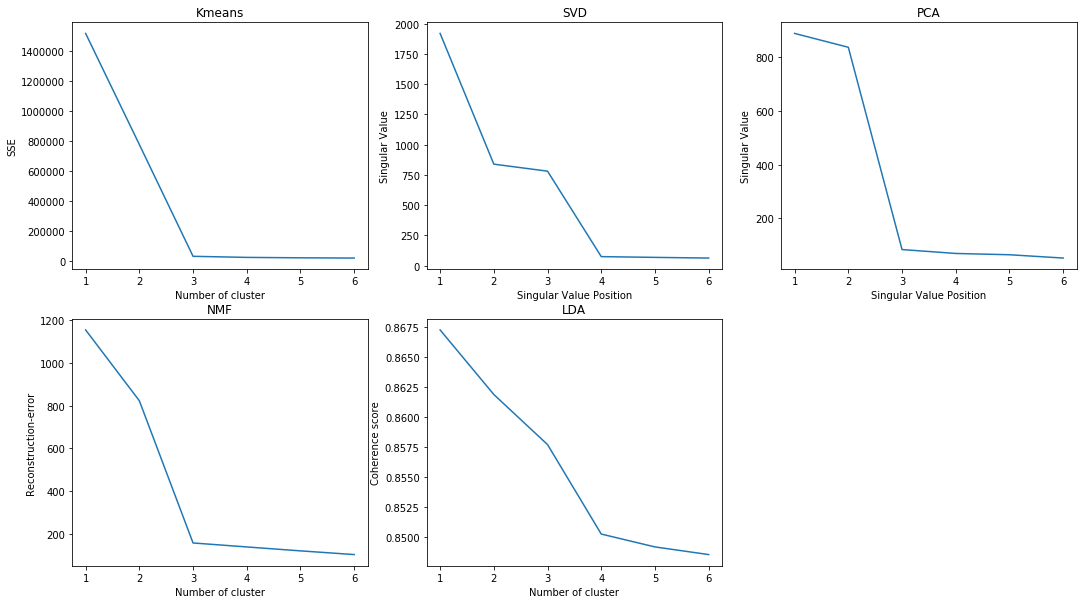

In [193]:
s.sub_plot_K(count_mat,6)

In [194]:
s.conf_mat(count_mat,3,label)

*********K-means*********
[[100   0   0]
 [  0  10   0]
 [  0   0  10]]
*********NMF*************
[[100   0   0]
 [  0   0  10]
 [  0  10   0]]
*********PCA*************
[[100   0   0]
 [  0   0  10]
 [  0  10   0]]
*********SVD**************
[[100   0   0]
 [  0  10   0]
 [  0   0  10]]
*********LDA**************
[[37 31 32]
 [ 0  0 10]
 [ 0  0 10]]
